# Assignment


1. change the `encoding_dim` through various values (`range(2,18,2)` and store or keep track of the best loss you can get. Plot the 8 pairs of dimensions vs loss on a scatter plot


In [1]:
# Import Packages
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
xtrain = xtrain.reshape((len(xtrain), np.prod(xtrain.shape[1:])))
xtest = xtest.reshape((len(xtest), np.prod(xtest.shape[1:])))
xtrain.shape, xtest.shape

((60000, 784), (10000, 784))

In [2]:
## Encoding Function

def auto_encoding(encoding_dim, xtrain, xtest):
    # Making Encoder, Decoder global variables for later use
    global encoder, decoder

    x = input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='relu')(x)
    # "decoded" is the lossy reconstruction of the input
    x = Dense(128, activation='relu')(encoded)
    x = Dense(256, activation='relu')(x)
    decoded = Dense(784, activation='sigmoid')(x)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    # Inputting 'encoding_dim'
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    dcd1 = autoencoder.layers[-1]
    dcd2 = autoencoder.layers[-2]
    dcd3 = autoencoder.layers[-3]

    # Create the decoder model
    decoder = Model(encoded_input, dcd1(dcd2(dcd3(encoded_input))))
    
    # Compile
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Fit
    fitting = autoencoder.fit(xtrain, xtrain,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(xtest, xtest),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])       
    # Capture Loss
    loss = fitting.history['loss']
    
    # Append (note: I changed 'losses' to 'losses for all models')
    losses_for_all_models.append(loss[-1])
    
    # Return Encoder, Decoder for later access
    encoder = Model(input_img, encoded)
    decoder = Model(encoded_input, dcd1(dcd2(dcd3(encoded_input))))
    return encoder, decoder

In [3]:
# Loopable List
r = range(2,18,2)
list(r)

[2, 4, 6, 8, 10, 12, 14, 16]

In [4]:
%%capture
losses_for_all_models = []
for encoding_dim in r:
    auto_encoding(encoding_dim, xtrain, xtest)   

In [5]:
losses_for_all_models

[0.16946054995059967,
 0.13751791417598724,
 0.12062659859657288,
 0.10934904217720032,
 0.12053185701370239,
 0.10097435861825943,
 0.09134490042924881,
 0.09346384555101395]

Text(0.5, 1.0, 'Loss Value vs Encoding Dimensions')

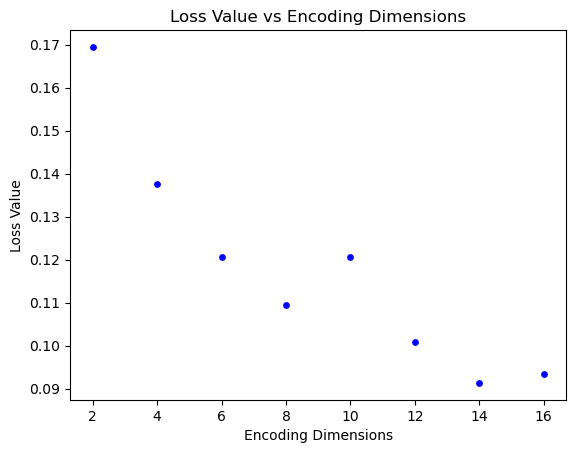

In [6]:
import matplotlib.pyplot as plt
plt.scatter(r, losses_for_all_models, s=15, c='blue')
plt.xlabel('Encoding Dimensions')
plt.ylabel('Loss Value')
plt.title('Loss Value vs Encoding Dimensions')

As the scatterplot shows, there is a negative correlation between the number of encoding dimensions and the final loss value; with more encoding dimensions, there is a lower resulting loss value. There is one outlier in the above data (at 10 dimensions), but the trend is still clear.



2. **_After_** training an autoencoder with `encoding_dim=8`, apply noise (like the previous assignment) to *_only_* the input of the trained autoencoder (not the output). The output images should be without noise. 

Print a few noisy images along with the output images to show they don't have noise.

In [7]:
## Noise

# Variables
loc = 0 
scale_values = 0.5

# Generate random noise with the same shape as the image
x_test_noise = np.random.normal(loc, scale_values, xtest.shape)

# Add noise
xtest_noise_added = xtest + x_test_noise # This will be the input into the trained autoencover

In [8]:
%%capture
encoding_dim = 8
auto_encoding(encoding_dim, xtrain, xtest)

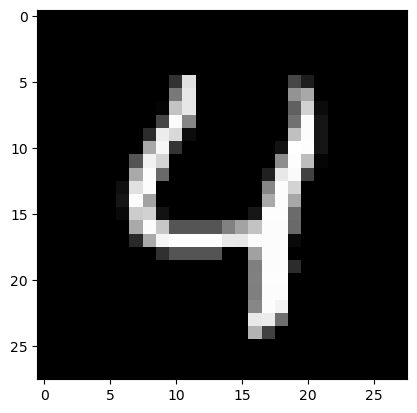

In [23]:
# Without Noise
plt.imshow(xtest[4].reshape(28,28))

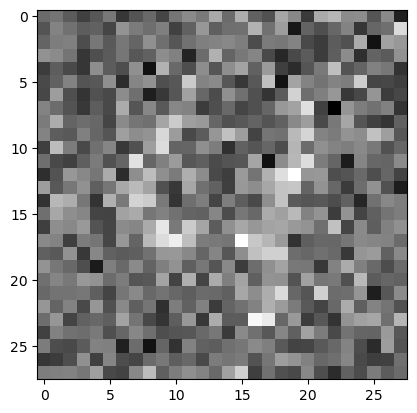

In [24]:
# With Noise
plt.imshow(xtest_noise_added[4].reshape(28,28))

In [25]:
# Encoding
encoded_imgs = encoder.predict(xtest_noise_added)
# Decoding
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 866us/step


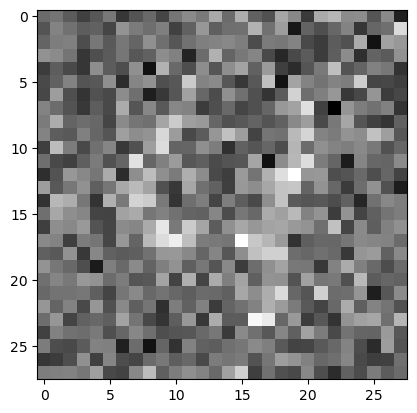

In [26]:
# Original Input Image, With Noise Applied, to Trained Autoencoder
plt.imshow(xtest_noise_added[4].reshape(28, 28))

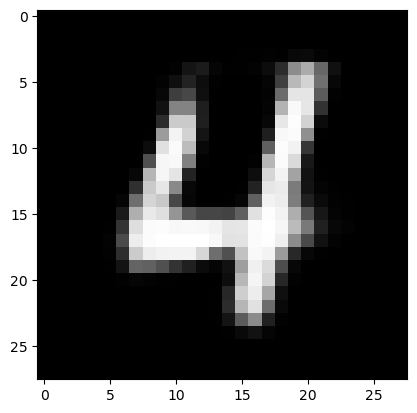

In [27]:
# Decoded image
plt.imshow(decoded_imgs[4].reshape(28,28))

The decoded image does not have noise, and is identifiable as a '4' (the digit represented in the test image). 

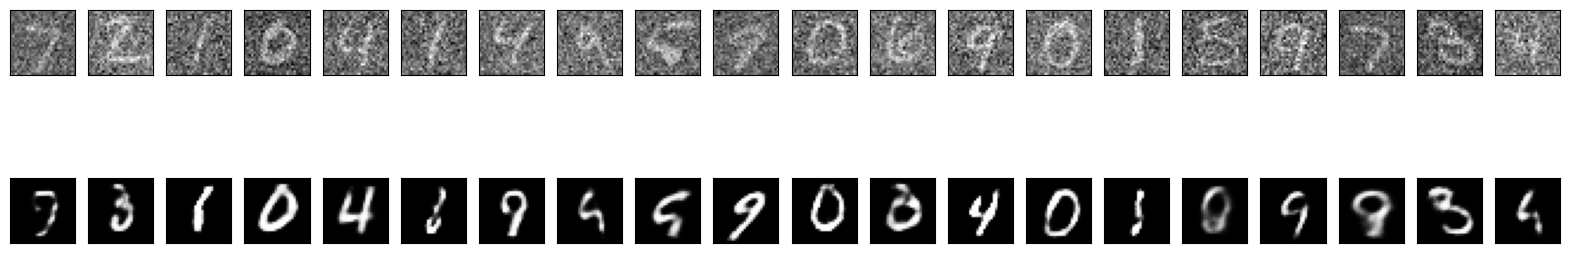

In [28]:
# Using code from the provided sheet to compare encoded images with resulting decoded images: 
n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xtest_noise_added[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Despite the noise added to the encoding inputs, the decoded images are legibile as the original digits, and furthermore do not have noise displayed. 